In [4]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional,GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense,SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy,SparseCategoricalCrossentropy,categorical_crossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sh import gunzip
import os
import tensorflow.keras as keras

In [5]:
import zipfile
with zipfile.ZipFile('alldata.zip', 'r') as zip_ref:
    zip_ref.extractall()

# version 2 of dataset

In [5]:
df=pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620007 entries, 0 to 620006
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    620007 non-null  object
 1   label   620007 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ MB


In [10]:
#part of dataset
df[70:80]

,text,label
70,سلام قای شانه چی عزیز خسته نباشی من امروز یه ...,0
71,سلام دوستان من کمتر از یک سال پیش 2 رو گرف...,0
72,تو حرف از کار گروهی نزن الدنگ با دو روز باز...,1
73,لطفا در مورد دانا هم راهنمایی بفرمایید,0
74,نگهداری فعلا,0
75,واقعا معتبره خبر من دوتاشو دارم,0
76,درصد خوباشم نیگاه میکنه پدرسوخته بد برا ما اش...,1
77,سنیر دارند جمع میکنند از صف فروش,0
78,دوستان پی ا س 4 خیلی بهتر از ایکس باکس هست ازن...,0
79,دوستان نوین رو چی کار کنم,0


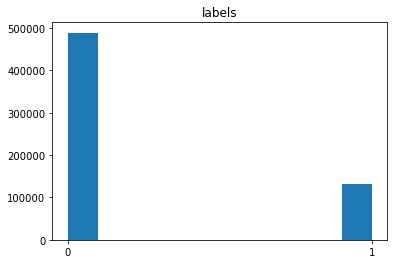

In [8]:
plt.hist(df['label']);plt.title('labels');plt.xticks([0,1])
plt.show()

## preprocessing the data :

In [7]:
dftrain,dftest=train_test_split(df,test_size=0.1)

In [8]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(dftrain['text'])
sectrain=tokenizer.texts_to_sequences(dftrain['text'])
sectest=tokenizer.texts_to_sequences(dftest['text'])

In [9]:
v=len(tokenizer.word_index)
v

347306

In [19]:
t=300
xtrain=pad_sequences(sectrain,maxlen=t)
xtest=pad_sequences(sectest,maxlen=t)

In [11]:
ytrain=np.array(dftrain['label'])
ytest=np.array(dftest['label'])

In [20]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(558006, 300)
(62001, 300)
(558006,)
(62001,)


## preparing fasttext persian embedding vector :

In [3]:
#download and unzip fasttext persian embedding vector
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz
gunzip('cc.fa.300.vec.gz')

--2022-09-11 14:53:17--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1258183862 (1.2G) [binary/octet-stream]
Saving to: ‘cc.fa.300.vec.gz’

cc.fa.300.vec.gz    100%[===================>]   1.17G  16.7MB/s    in 94s     

2022-09-11 14:54:52 (12.8 MB/s) - ‘cc.fa.300.vec.gz’ saved [1258183862/1258183862]



In [4]:
embeddings_index = {}
f = open('cc.fa.300.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 2000000 word vectors.


In [13]:
embedding_matrix = np.zeros((v + 1, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## setting up the model :
#### using a better model architecture than the last model

In [22]:
model=Sequential()

model.add(Embedding(v+1,300,input_length=300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(128,dropout=0.2,return_sequences=True))
model.add(LSTM(64,dropout=0.2,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation='sigmoid'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          104192100 
                                                                 
 lstm_2 (LSTM)               (None, 300, 128)          219648    
                                                                 
 lstm_3 (LSTM)               (None, 300, 64)           49408     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 104,461,221
Trainable params: 269,121
Non-trainable params: 104,192,100
__________________________________

In [24]:
model.compile(loss=binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [25]:
#saving weights on each epoch

output_dir = 'model_output/LSTM'
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [26]:
r=model.fit(
            xtrain,ytrain,
            batch_size=128,
            epochs=6,
            validation_data=(xtest,ytest),
            callbacks=[modelcheckpoint]
           )

Epoch 1/6
4360/4360 [==============================] - 206s 47ms/step - loss: 0.1049 - accuracy: 0.9611 - val_loss: 0.0746 - val_accuracy: 0.9736
Epoch 2/6
4360/4360 [==============================] - 209s 48ms/step - loss: 0.0741 - accuracy: 0.9736 - val_loss: 0.0670 - val_accuracy: 0.9766
Epoch 3/6
4360/4360 [==============================] - 206s 47ms/step - loss: 0.0650 - accuracy: 0.9773 - val_loss: 0.0587 - val_accuracy: 0.9795
Epoch 4/6
4360/4360 [==============================] - 204s 47ms/step - loss: 0.0588 - accuracy: 0.9796 - val_loss: 0.0557 - val_accuracy: 0.9804
Epoch 5/6
4360/4360 [==============================] - 205s 47ms/step - loss: 0.0545 - accuracy: 0.9812 - val_loss: 0.0553 - val_accuracy: 0.9810
Epoch 6/6
4360/4360 [==============================] - 205s 47ms/step - loss: 0.0514 - accuracy: 0.9824 - val_loss: 0.0535 - val_accuracy: 0.9817


## analysing model's behavior :

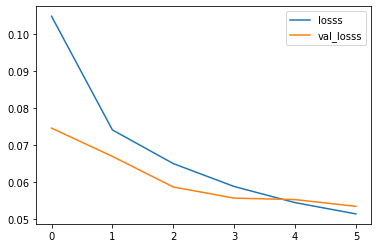

In [28]:
plt.plot(r.history['loss'],label='losss')
plt.plot(r.history['val_loss'],label='val_losss')
plt.xticks(range(6))
plt.legend();

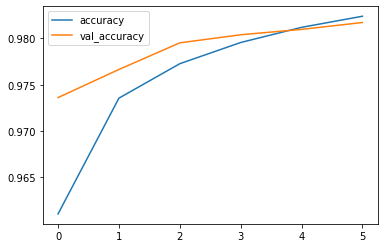

In [29]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.xticks(range(6))
plt.legend();

In [67]:
#loading weights of best epoch

model.load_weights(output_dir+"/weights.04.hdf5")

In [31]:
tpr=model.predict(xtest)

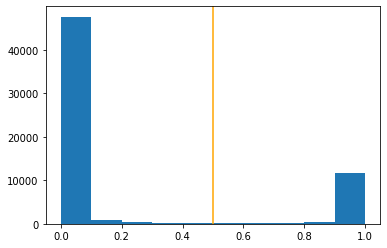

In [32]:
plt.hist(tpr)
_ = plt.axvline(x=0.5, color='orange')

## AUC score :
#### better AUC score than the last model

In [33]:
"{:0.2f}".format(roc_auc_score(ytest,tpr)*100.0)

'99.62'

## testing model :

In [34]:
def predict(st):                               
    st=[st]
    st=tokenizer.texts_to_sequences(st)
    st=pad_sequences(st,maxlen=t)
    v=model.predict(st)
    if v[0][0]>0.5: return 'insult',v[0][0]
    else: return 'normal',v[0][0]

In [68]:
predict('واقعا که خاک بریزن تو چاله')

('normal', 0.33164203)

In [69]:
predict('واقعا که خاک بریزن تو سرت')

('insult', 0.9853952)

In [70]:
predict('زر و نقره')

('normal', 0.23938324)

In [71]:
predict('زر نزن')

('insult', 0.9737915)

## latest issues fixed :

In [72]:
predict('جاتا')

('normal', 0.37942293)

In [73]:
predict('سپیده')

('normal', 0.107946)